# Markowitz++ with Options — Demo Notebook

This notebook provides:
1. **Data snapshot** — what we have, quality checks
2. **RND distributions** — visualize the risk-neutral density for each asset
3. **Parameter dashboard** — current hyperparameters, easy to tweak
4. **Backtest runner** — change params and re-run in one cell

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.use("agg")

import sys, os, logging, importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

PROJECT_ROOT = Path(os.getcwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

logging.basicConfig(level=logging.WARNING, force=True)
logging.getLogger("data.forecasts").setLevel(logging.WARNING)

import config
import data.forecasts as _forecasts_mod
import backtest as bt
importlib.reload(config)
importlib.reload(_forecasts_mod)
importlib.reload(bt)

from config import (
    SPY_DAILY_FILE, OPTION_CHAINS_DIR, CASH_RATE_FILE,
    TARGET_MIN_DTE, TARGET_MAX_DTE, TARGET_IDEAL_DTE,
    REBALANCE_DAYS, OPTION_RETURN_WINSORIZE_PCT,
    MIN_BL_STRIKES, MIN_OPTION_MID, MAX_BID_ASK_SPREAD_PCT,
    PROCESSED_DIR,
)
from data.forecasts import (
    compute_rnd_forecasts, load_chain_for_expiry, ASSET_ORDER,
    _get_atm_iv, _bs_call_price, _bs_put_price,
    _lognormal_sample, breeden_litzenberger_pdf,
    _bs_call_vec, _bs_put_vec,
)

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "font.size": 10,
})
print("Imports OK")

Imports OK


---
## 1  Data Snapshot

In [2]:
# SPY equity bars
spy = pd.read_parquet(SPY_DAILY_FILE)
spy.index = pd.to_datetime(spy.index).tz_localize(None).normalize()
print(f"SPY bars: {len(spy):,}  ({spy.index[0].date()} to {spy.index[-1].date()})")
print(f"Latest close: ${spy['close'].iloc[-1]:.2f}")

# Option chain dates
chain_dates = sorted(set(
    f.stem.replace("calls_", "")
    for f in OPTION_CHAINS_DIR.glob("calls_*.parquet")
    if (OPTION_CHAINS_DIR / f"puts_{f.stem.replace('calls_','')}.parquet").exists()
))
print(f"Option chain snapshots: {len(chain_dates)}")
print(f"  First: {chain_dates[0]}   Last: {chain_dates[-1]}")

# Quick chain quality for the latest date
d = chain_dates[-1]
calls_raw = pd.read_parquet(OPTION_CHAINS_DIR / f"calls_{d}.parquet")
puts_raw  = pd.read_parquet(OPTION_CHAINS_DIR / f"puts_{d}.parquet")
print(f"\nLatest chain ({d}):")
print(f"  Calls: {len(calls_raw)}   Puts: {len(puts_raw)}")
for label, df in [("Calls", calls_raw), ("Puts", puts_raw)]:
    cols_lower = [c.lower() for c in df.columns]
    has_bid = any('bid' in c for c in cols_lower)
    has_iv  = any('implied' in c or 'impl_vol' in c for c in cols_lower)
    print(f"  {label} — columns: {list(df.columns[:8])}{'...' if len(df.columns)>8 else ''}")
    if has_bid:
        bid_col = [c for c in df.columns if 'bid' in c.lower()][0]
        print(f"    bid > 0: {(df[bid_col] > 0).sum()}/{len(df)} ({(df[bid_col] > 0).mean():.0%})")

SPY bars: 534  (2024-01-02 to 2026-02-18)
Latest close: $686.29
Option chain snapshots: 39
  First: 2024-02-01   Last: 2026-02-18

Latest chain (2026-02-18):
  Calls: 675   Puts: 675
  Calls — columns: ['contractSymbol', 'expiry', 'strike', 'lastPrice', 'bid', 'ask', 'impliedVolatility', 'delta']...
    bid > 0: 644/675 (95%)
  Puts — columns: ['contractSymbol', 'expiry', 'strike', 'lastPrice', 'bid', 'ask', 'impliedVolatility', 'delta']...
    bid > 0: 675/675 (100%)


In [3]:
# SPY price history
fig, ax = plt.subplots(figsize=(12, 3.5))
ax.plot(spy.index, spy["close"], color="#2563eb", linewidth=1.2)
for d in chain_dates:
    ax.axvline(pd.Timestamp(d), color="orange", alpha=0.15, linewidth=0.8)
ax.set_title("SPY Close  (orange = chain snapshot dates)")
ax.set_ylabel("Price ($)")
plt.tight_layout()
display(fig)
plt.close(fig)

/var/folders/v7/fy28j8pd6yb_vb5vddcfccd00000gn/T/ipykernel_28508/2964850703.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


---
## 2  RND Distributions

We compute the Risk-Neutral Distribution for a **single recent chain date** and visualize:
- The sampled terminal spot distribution (BL or lognormal fallback)
- Implied return distributions for SPY, Call, Put, and Cash

In [4]:
# Pick a chain date to inspect (latest by default)
DEMO_DATE = chain_dates[-1]

ts = pd.Timestamp(DEMO_DATE)
idx = spy.index.get_indexer([ts], method="ffill")[0]
spot = float(spy.iloc[idx]["close"])

mu, Sigma, diag = compute_rnd_forecasts(
    chain_date=DEMO_DATE, spot=spot, n_samples=20_000, return_diagnostics=True,
)

print(f"Chain date: {DEMO_DATE}   Spot: ${spot:.2f}")
print(f"Method: {diag['method']}")
print(f"Expiry: {diag['expiry']}  DTE: {diag['dte']}")
print(f"ATM IV: {diag['atm_iv']:.2%}")
print(f"K_ATM: {diag['k_atm']:.0f}   C_ATM: ${diag['c_atm']:.4f}   P_ATM: ${diag['p_atm']:.4f}")
print(f"Calls after filter: {diag['n_calls_after_filter']}   Puts: {diag['n_puts_after_filter']}")
print(f"BL interior strikes: {diag['n_interior_strikes']}")
print(f"Mode: {'hold-to-expiry' if not diag['horizon_reprice'] else 'horizon-reprice'}")

Chain date: 2026-02-18   Spot: $686.29
Method: breeden_litzenberger
Expiry: 2026-03-06  DTE: 16
ATM IV: 17.25%
K_ATM: 686   C_ATM: $10.3400   P_ATM: $8.9800
Calls after filter: 118   Puts: 133
BL interior strikes: 116
Mode: hold-to-expiry


In [5]:
print("\n===  mu (expected return per period)  ===")
for asset in ASSET_ORDER:
    print(f"  {asset:12s} {mu[asset]:+.4%}")

print("\n===  Sigma (covariance matrix)  ===")
print(Sigma.to_string(float_format="{:.6f}".format))

stds = np.sqrt(np.diag(Sigma.values))
corr = Sigma.values / np.outer(stds + 1e-12, stds + 1e-12)
print("\n===  Correlations  ===")
print(pd.DataFrame(corr, index=ASSET_ORDER, columns=ASSET_ORDER).to_string(float_format="{:.3f}".format))


===  mu (expected return per period)  ===
  SPY          -3.0856%
  SPY_CALL     -27.6328%
  SPY_PUT      +30.0000%
  USDOLLAR     +0.2194%

===  Sigma (covariance matrix)  ===
               SPY  SPY_CALL   SPY_PUT  USDOLLAR
SPY       0.003583  0.005389 -0.007020 -0.000000
SPY_CALL  0.005389  0.014330 -0.008672 -0.000000
SPY_PUT  -0.007020 -0.008672  0.014330 -0.000000
USDOLLAR -0.000000 -0.000000 -0.000000  0.000000

===  Correlations  ===
            SPY  SPY_CALL  SPY_PUT  USDOLLAR
SPY       1.000     0.752   -0.980    -0.000
SPY_CALL  0.752     1.000   -0.605    -0.000
SPY_PUT  -0.980    -0.605    1.000    -0.000
USDOLLAR -0.000    -0.000   -0.000     1.000


In [6]:
# Re-sample for plotting (separate call to get the raw S_next)
np.random.seed(42)
T = diag["T_expiry_years"]
T_rebal = diag["T_rebal_years"]
T_remain = diag["T_remain_years"]
atm_iv = diag["atm_iv"]
r = 0.05
k_atm = diag["k_atm"]
c_atm = diag["c_atm"]
p_atm = diag["p_atm"]

T_sample = T_rebal if REBALANCE_DAYS else T
S_next = _lognormal_sample(spot, r, T_sample, atm_iv, 50_000)
r_spy  = S_next / spot - 1.0

# Horizon repricing: BS-reprice options at rebalance with remaining time
if T_remain > 1e-6:
    C_t1 = _bs_call_vec(S_next, k_atm, r, T_remain, atm_iv)
    P_t1 = _bs_put_vec(S_next, k_atm, r, T_remain, atm_iv)
    mode_label = f"Horizon reprice (T_remain={T_remain:.3f}yr)"
else:
    C_t1 = np.maximum(S_next - k_atm, 0.0)
    P_t1 = np.maximum(k_atm - S_next, 0.0)
    mode_label = "Terminal payoff (T_remain≈0)"
r_call = C_t1 / c_atm - 1.0
r_put  = P_t1 / p_atm - 1.0
r_cash = np.full_like(S_next, np.exp(r * T_sample) - 1.0)
print(f"Pricing mode: {mode_label}")

fig, axes = plt.subplots(2, 2, figsize=(13, 8))
fig.suptitle(
    f"RND Return Distributions — {DEMO_DATE}  (DTE={diag['dte']}, IV={atm_iv:.1%})",
    fontsize=13, fontweight="bold",
)

configs = [
    (axes[0, 0], r_spy,  "SPY",        "#2563eb", (-0.15, 0.15)),
    (axes[0, 1], r_call, "ATM Call",    "#16a34a", (-0.6, 1.0)),
    (axes[1, 0], r_put,  "ATM Put",     "#dc2626", (-0.6, 1.0)),
    (axes[1, 1], r_cash, "Cash (T-bill)", "#f59e0b", None),
]

for ax, data, label, color, xlim in configs:
    clipped = np.clip(data, -1.5, 10.0)
    ax.hist(clipped, bins=120, density=True, color=color, alpha=0.7, edgecolor="none")
    ax.axvline(np.mean(data), color="k", linestyle="--", linewidth=1.2,
               label=f"mean={np.mean(data):.4f}")
    ax.axvline(np.median(data), color="gray", linestyle=":", linewidth=1.0,
               label=f"median={np.median(data):.4f}")
    ax.set_title(f"{label}  (std={np.std(data):.4f})")
    ax.legend(fontsize=8)
    if xlim:
        ax.set_xlim(xlim)

plt.tight_layout()
display(fig)
plt.close(fig)

/var/folders/v7/fy28j8pd6yb_vb5vddcfccd00000gn/T/ipykernel_28508/2540086660.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [7]:
# Spot distribution
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(S_next, bins=150, density=True, color="#6366f1", alpha=0.7, edgecolor="none")
ax.axvline(spot, color="red", linewidth=2, label=f"Current spot=${spot:.0f}")
ax.axvline(np.mean(S_next), color="k", linewidth=1.5, linestyle="--",
           label=f"E[S_T]=${np.mean(S_next):.1f}")
ax.axvline(k_atm, color="green", linewidth=1.5, linestyle=":",
           label=f"K_ATM=${k_atm:.0f}")
ax.set_title(f"Sampled Terminal Spot Distribution — {diag['method']}")
ax.set_xlabel("S_T ($)")
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

/var/folders/v7/fy28j8pd6yb_vb5vddcfccd00000gn/T/ipykernel_28508/2321165621.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


---
## 3  Parameter Dashboard

All tunable parameters in one place.  
**Change values below, then re-run section 4 to see the effect.**

In [8]:
# ====================================================================
#  TUNABLE PARAMETERS — edit these and re-run Section 4
# ====================================================================

# Risk aversion: higher = less risky portfolio (penalizes variance in objective)
GAMMA = 10.0

# Hard portfolio volatility cap per period (SOCP constraint)
# e.g. 0.03 means sqrt(w'Σw) <= 3% per ~14-day period
MAX_PORT_VOL = 0.04

# Maximum weight in each option sleeve
MAX_OPTION_WEIGHT = 0.10

# Minimum cash allocation (floor)
MIN_CASH_WEIGHT = 0.10

# Maximum turnover per rebalance (L1 norm)
MAX_TURNOVER = 0.40

# Transaction cost rate (fraction of turnover)
TCOST_RATE = 0.001

# Rolling window for historical mu (number of periods)
ROLLING_WINDOW = 13

# Shrinkage of rolling mu toward cash rate (0 = pure historical, 1 = all cash rate)
MU_SHRINKAGE = 0.5

print("Parameters set:")
print(f"  GAMMA           = {GAMMA}")
print(f"  MAX_PORT_VOL    = {MAX_PORT_VOL:.2%} per period")
print(f"  MAX_OPTION_WT   = {MAX_OPTION_WEIGHT:.0%}")
print(f"  MIN_CASH_WT     = {MIN_CASH_WEIGHT:.0%}")
print(f"  MAX_TURNOVER    = {MAX_TURNOVER}")
print(f"  TCOST_RATE      = {TCOST_RATE}")
print(f"  ROLLING_WINDOW  = {ROLLING_WINDOW}")
print(f"  MU_SHRINKAGE    = {MU_SHRINKAGE}")

Parameters set:
  GAMMA           = 10.0
  MAX_PORT_VOL    = 4.00% per period
  MAX_OPTION_WT   = 10%
  MIN_CASH_WT     = 10%
  MAX_TURNOVER    = 0.4
  TCOST_RATE      = 0.001
  ROLLING_WINDOW  = 13
  MU_SHRINKAGE    = 0.5


---
## 4  Run Backtest

This cell patches the `backtest` module with the parameters above and re-runs the experiment.

In [9]:
# Patch backtest module with notebook parameters
bt.GAMMA = GAMMA
bt.MAX_PORT_VOL = MAX_PORT_VOL
bt.MAX_OPTION_WEIGHT = MAX_OPTION_WEIGHT
bt.MIN_CASH_WEIGHT = MIN_CASH_WEIGHT
bt.MAX_TURNOVER = MAX_TURNOVER
bt.TCOST_RATE = TCOST_RATE
bt.ROLLING_WINDOW = ROLLING_WINDOW
bt.MU_SHRINKAGE = MU_SHRINKAGE

print("Running backtest with updated parameters ...")
portfolio_df, weights_df, returns, mu_df, diag_summary = bt.run_backtest()

pv = portfolio_df["value"].values
spy_cum = (1 + returns["SPY"]).cumprod()
period_rets = np.diff(pv) / pv[:-1]
ann_factor = np.sqrt(252 / max(bt.REBAL_DAYS, 1))

print("\n========== Results ==========")
print(f"Periods:  {diag_summary['n_periods']}")
print(f"Range:    {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Return:   {pv[-1] / pv[0] - 1:+.2%}  (SPY B&H: {spy_cum.iloc[-1] - 1:+.2%})")
print(f"Sharpe:   {np.mean(period_rets) / (np.std(period_rets) + 1e-12) * ann_factor:.2f}")
print(f"Vol (ann): {np.std(period_rets) * ann_factor:.2%}")
print(f"Max DD:   {np.min(pv / np.maximum.accumulate(pv)) - 1:.1%}")
print(f"BL used:  {diag_summary['n_bl']}/{diag_summary['n_rnd_computed']}")

Running backtest with updated parameters ...

========== Results ==========
Periods:  38
Range:    2024-02-22 to 2026-02-18
Return:   -33.66%  (SPY B&H: +40.29%)
Sharpe:   -0.05
Vol (ann): 62.88%
Max DD:   -64.1%
BL used:  39/39


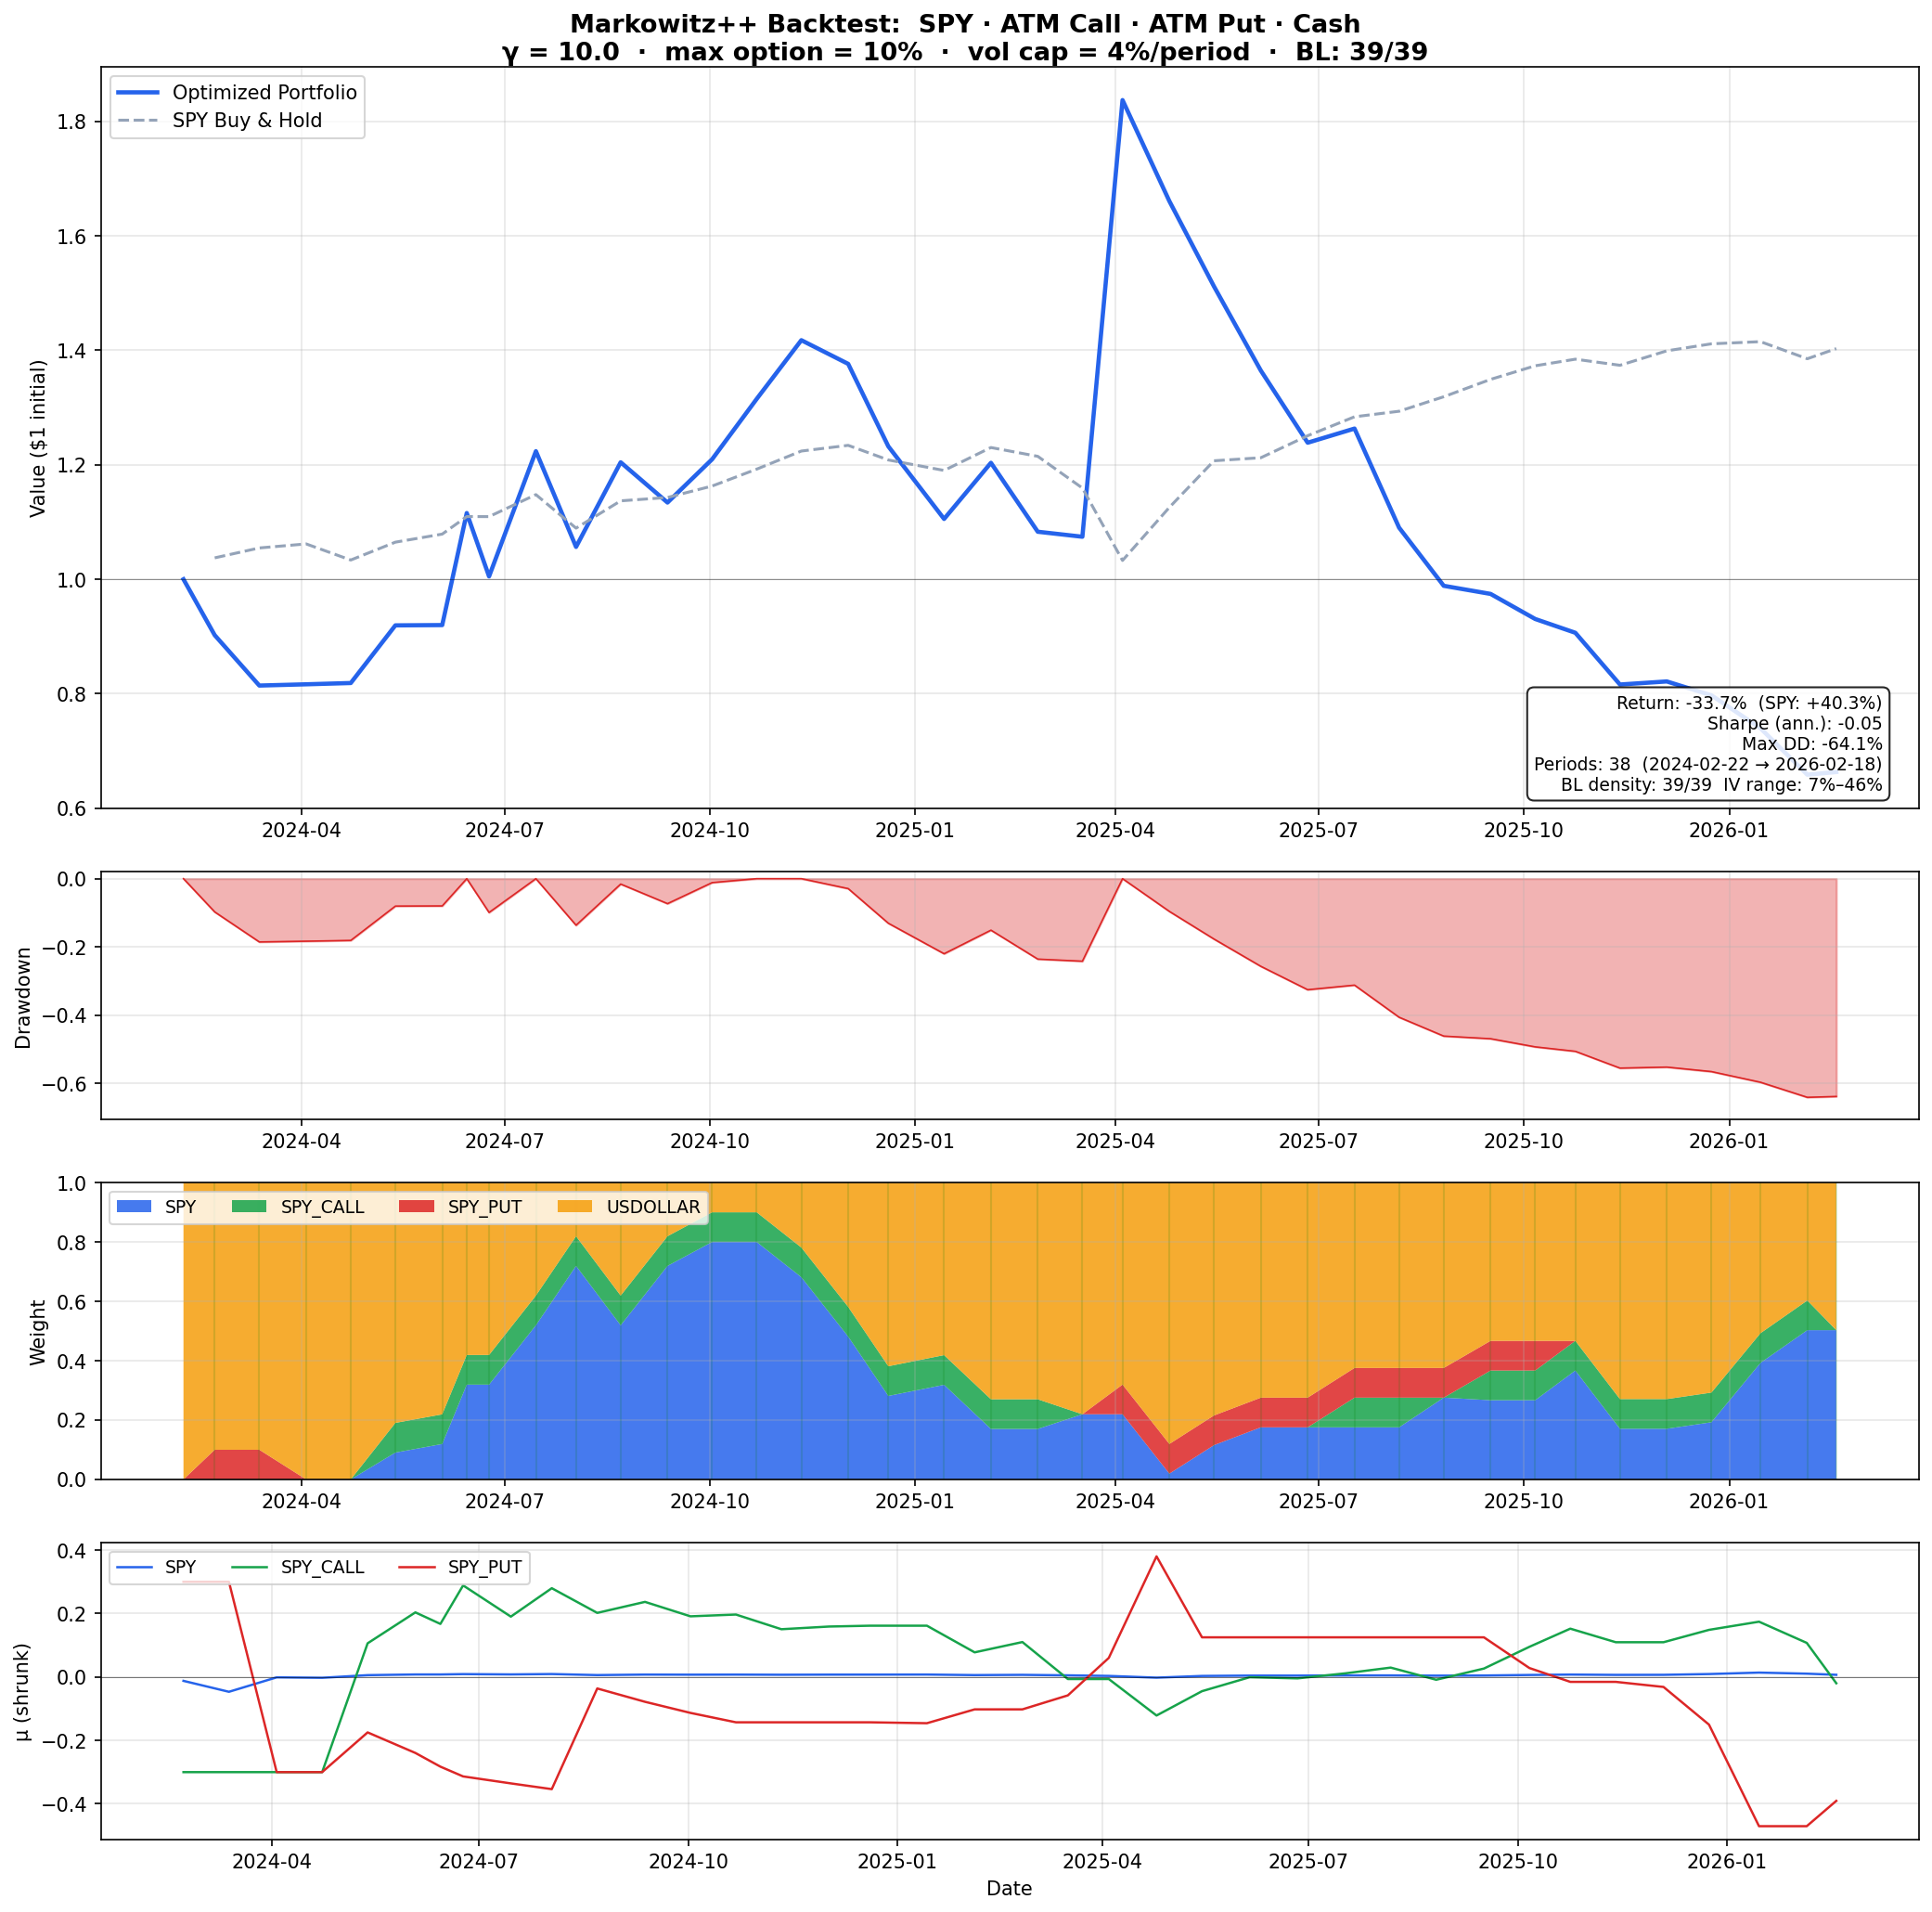

In [10]:
# Plot results
save_path = str(PROCESSED_DIR / "backtest_results.png")
bt.plot_results(portfolio_df, weights_df, returns, mu_df, diag_summary, save_path=save_path)

from IPython.display import Image, display
display(Image(filename=save_path, width=900))

In [11]:
# Allocation breakdown at final period
print("Final weights:")
for asset in ASSET_ORDER:
    print(f"  {asset:12s} {weights_df[asset].iloc[-1]:6.1%}")

# Period-level portfolio vol vs SPY vol
port_vol = np.std(period_rets)
spy_vol  = returns["SPY"].std()
print(f"\nPer-period vol: Portfolio={port_vol:.4f}  SPY={spy_vol:.4f}  Ratio={port_vol/spy_vol:.2f}x")
print(f"Annualized vol: Portfolio={port_vol*ann_factor:.2%}  SPY={spy_vol*ann_factor:.2%}")

Final weights:
  SPY           50.3%
  SPY_CALL       0.0%
  SPY_PUT        0.0%
  USDOLLAR      49.7%

Per-period vol: Portfolio=0.1482  SPY=0.0336  Ratio=4.41x
Annualized vol: Portfolio=62.88%  SPY=14.25%


---
## 5  Experiment: Parameter Sensitivity

Sweep a parameter to see its effect on Sharpe and vol.

In [12]:
# Sweep GAMMA to see how risk aversion affects the backtest
# (This takes a few minutes — each run recomputes RND for all periods)

SWEEP_GAMMAS = [2, 5, 10, 20, 50]

results_sweep = []
for g in SWEEP_GAMMAS:
    bt.GAMMA = g
    bt.MAX_PORT_VOL = MAX_PORT_VOL  # keep vol cap constant
    bt.MAX_OPTION_WEIGHT = MAX_OPTION_WEIGHT
    bt.MIN_CASH_WEIGHT = MIN_CASH_WEIGHT
    pf, wf, ret, mf, ds = bt.run_backtest()
    pv_ = pf["value"].values
    pr_ = np.diff(pv_) / pv_[:-1]
    sharpe_ = np.mean(pr_) / (np.std(pr_) + 1e-12) * ann_factor
    vol_   = np.std(pr_) * ann_factor
    total_ = pv_[-1] / pv_[0] - 1
    results_sweep.append({"gamma": g, "return": total_, "sharpe": sharpe_, "ann_vol": vol_})
    print(f"gamma={g:>3}  return={total_:+.2%}  sharpe={sharpe_:.2f}  vol={vol_:.2%}")

# Restore
bt.GAMMA = GAMMA

sweep_df = pd.DataFrame(results_sweep)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.plot(sweep_df["gamma"], sweep_df["sharpe"], "o-", color="#2563eb")
ax1.set_xlabel("gamma")
ax1.set_ylabel("Annualized Sharpe")
ax1.set_title("Sharpe vs Risk Aversion")

ax2.plot(sweep_df["gamma"], sweep_df["ann_vol"] * 100, "s-", color="#dc2626")
ax2.set_xlabel("gamma")
ax2.set_ylabel("Annualized Vol (%)")
ax2.set_title("Volatility vs Risk Aversion")

plt.tight_layout()
display(fig)
plt.close(fig)

gamma=  2  return=-33.76%  sharpe=-0.06  vol=62.93%
gamma=  5  return=-33.68%  sharpe=-0.05  vol=62.91%
gamma= 10  return=-33.74%  sharpe=-0.06  vol=62.89%
gamma= 20  return=-33.76%  sharpe=-0.06  vol=62.91%
gamma= 50  return=-33.75%  sharpe=-0.06  vol=62.91%


/var/folders/v7/fy28j8pd6yb_vb5vddcfccd00000gn/T/ipykernel_28508/532013531.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
